In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
%reload_ext autoreload
%autoreload 2

In [14]:
namesngenre = np.load('./dataset/namesngenre.npy')

In [15]:
namesngenre

array([['Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       ['Jumanji (1995)', 'Adventure|Children|Fantasy'],
       ['Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       ['Elsa & Fred (2005)', 'Comedy|Drama|Romance'],
       ['Tomb Raider (2018)', 'Action|Adventure|Fantasy'],
       ['Fred Armisen: Standup for Drummers (2018)', 'Comedy']],
      dtype='<U158')

In [16]:
ratings_train = np.load('./dataset/ratings_train.npy')

In [17]:
ratings_train.shape

(610, 4980)

In [18]:
ratings_train

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  2., nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [19]:
np.nanmax(ratings_train)


5.0

In [20]:
np.nanmin(ratings_train)

0.5

# Matrix Factorization

In [21]:
import MF

In [22]:
k = 1

factorization = MF.MF(ratings_train, l=0.01, mu=0.01, k=k)


In [23]:
non_nan_indices = np.where(~np.isnan(ratings_train))
print(non_nan_indices)
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = factorization.R[row_indices, col_indices]

(array([  0,   0,   0, ..., 609, 609, 609], dtype=int64), array([   0,   44,   58, ..., 4928, 4929, 4937], dtype=int64))


In [24]:
factorization.fit(lr_I=0.0001, lr_U=0.0001, num_iterations=100)
prediction_full = factorization.predict()
prediction = prediction_full[row_indices, col_indices]
print(prediction)
factorization.RMSE_(prediction_full)

Iteration 1: Cost = 32392.999775727294. RMSE = 1.0094178556936002
Iteration 2: Cost = 31379.13921235615. RMSE = 0.9933969755194786
Iteration 3: Cost = 30618.05845467384. RMSE = 0.9811983620094424
Iteration 4: Cost = 30009.30220732772. RMSE = 0.9713307438572282
Iteration 5: Cost = 29502.756415628777. RMSE = 0.9630426867605009
Iteration 6: Cost = 29070.13009088203. RMSE = 0.9559070809645166
Iteration 7: Cost = 28693.74438039374. RMSE = 0.9496553845545416
Iteration 8: Cost = 28361.6839916821. RMSE = 0.9441054790234434
Iteration 9: Cost = 28065.46999072267. RMSE = 0.9391269580102453
Iteration 10: Cost = 27798.824657134937. RMSE = 0.934622676738243
Iteration 11: Cost = 27556.95734882301. RMSE = 0.9305180618239591
Iteration 12: Cost = 27336.123155609286. RMSE = 0.9267544853716159
Iteration 13: Cost = 27133.336150502648. RMSE = 0.9232849455999945
Iteration 14: Cost = 26946.175841176915. RMSE = 0.9200711413645253
Iteration 15: Cost = 26772.652478989065. RMSE = 0.917081429536286
Iteration 16: C

0.8384281041625187

0.8998834238908144


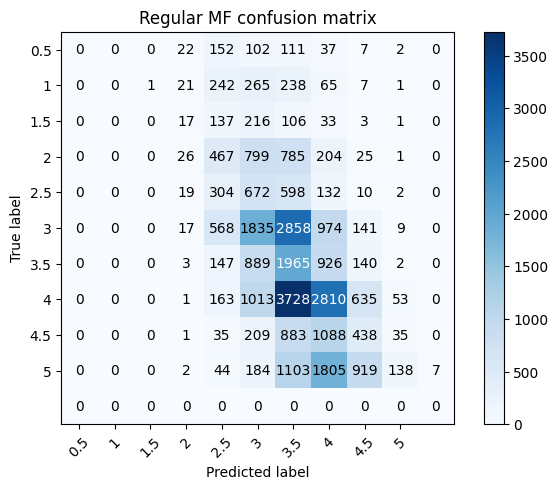

Accuracy: 23.79%


In [25]:
targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = np.round(prediction_full * 2)/2
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, title='Regular MF confusion matrix')
# Calculate the accuracy
correct_predictions = np.sum(targets[targets!=0] == predictions[targets!=0])
total_predictions = len(targets[targets!=0])

accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy * 100:.2f}%")

# Deep Matrix Factorization


In [26]:
import deepMF
import torch
import torch.nn as nn
import torch.optim as optim
%reload_ext autoreload
%autoreload 2

In [27]:
# Load the input data from a numpy file
ratings_train = np.load('dataset/ratings_train.npy')
ratings_test = np.load('dataset/ratings_test.npy')
# Replace NaN values with 0
ratings_train[np.isnan(ratings_train)] = 0
ratings_test[np.isnan(ratings_test)] = 0

In [28]:
total_data = ratings_train + ratings_test

non_empty_indices = np.where(total_data != 0)
non_empty_indices = np.array([non_empty_indices[0], non_empty_indices[1]])

indices = np.random.choice(np.array(range(non_empty_indices.shape[1])), size=non_empty_indices.shape[1], replace = False)

train_set_indices = indices[0:int(non_empty_indices.shape[1]*0.7)]
train_set_indices2d = np.array(non_empty_indices[:, train_set_indices])
train_set = np.zeros(total_data.shape)
train_set[train_set_indices2d[0], train_set_indices2d[1]] = total_data[train_set_indices2d[0], train_set_indices2d[1]]

test_set_indices = indices[int(non_empty_indices.shape[1]*0.7):]
test_set_indices2d = np.array(non_empty_indices[:, test_set_indices])
test_set = np.zeros(total_data.shape)
test_set[test_set_indices2d[0], test_set_indices2d[1]] = total_data[test_set_indices2d[0], test_set_indices2d[1]]

normalized_train_data = train_set/np.max(train_set)

normalized_test_data = test_set/np.max(test_set)

In [29]:
# Hyperparameters evaluation
encoded_dim = 32
input_size = normalized_train_data.shape 
hidden_size_row = 16
hidden_size_col = 64

In [30]:
import time

In [31]:
# Start the timer
start_time = time.time()
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
deepMF.train_model(model, optimizer, torch.FloatTensor(normalized_train_data), test_data=test_set)
# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch [1/250], Loss: 0.034220
Epoch [2/250], Loss: 0.026918
Epoch [3/250], Loss: 0.021011
Epoch [4/250], Loss: 0.016383
Epoch [5/250], Loss: 0.013504
Epoch [6/250], Loss: 0.011702
Epoch [7/250], Loss: 0.010567
Epoch [8/250], Loss: 0.009863
Epoch [9/250], Loss: 0.009428
Epoch [10/250], Loss: 0.009159
Epoch [11/250], Loss: 0.008991
Epoch [12/250], Loss: 0.008883
Epoch [13/250], Loss: 0.008817
Epoch [14/250], Loss: 0.008782
Epoch [15/250], Loss: 0.008773
Epoch [16/250], Loss: 0.008782
Epoch [17/250], Loss: 0.008799
Epoch [18/250], Loss: 0.008813
Epoch [19/250], Loss: 0.008822
Epoch [20/250], Loss: 0.008826
Epoch [21/250], Loss: 0.008826
Epoch [22/250], Loss: 0.008823
Epoch [23/250], Loss: 0.008820
Epoch [24/250], Loss: 0.008816
Epoch [25/250], Loss: 0.008812
Epoch [26/250], Loss: 0.008806
Epoch [27/250], Loss: 0.008800
Epoch [28/250], Loss: 0.008794
Epoch [29/250], Loss: 0.008787
Epoch [30/250], Loss: 0.008780
Epoch [31/250], Loss: 0.008772
Epoch [32/250], Loss: 0.008764
Epoch [33/250], L

[3.488349676132202, 3.2830588817596436, 2.9497618675231934, 2.5483715534210205, 2.1814980506896973, 1.87100350856781, 1.6204049587249756, 1.4298213720321655, 1.290891408920288, 1.1935032606124878, 1.1262731552124023, 1.0803717374801636, 1.0501822233200073, 1.032271146774292, 1.0238873958587646, 1.0224112272262573, 1.024417519569397, 1.0270849466323853, 1.0288344621658325, 1.0294898748397827, 1.029266357421875, 1.0285323858261108, 1.0274219512939453, 1.0261353254318237, 1.0246378183364868, 1.0229134559631348, 1.0210301876068115, 1.019029140472412, 1.0169295072555542, 1.0147327184677124, 1.0123581886291504, 1.0098339319229126, 1.0072031021118164, 1.0044509172439575, 1.0016849040985107, 0.9988659620285034, 0.9961419701576233, 0.9938092231750488, 0.9920303225517273, 0.9906049966812134, 0.9892256855964661, 0.987707257270813, 0.9859582781791687, 0.9839920997619629, 0.9819639325141907, 0.9801284670829773, 0.978560745716095, 0.9772611260414124, 0.9761132001876831, 0.9749906659126282, 0.9739025

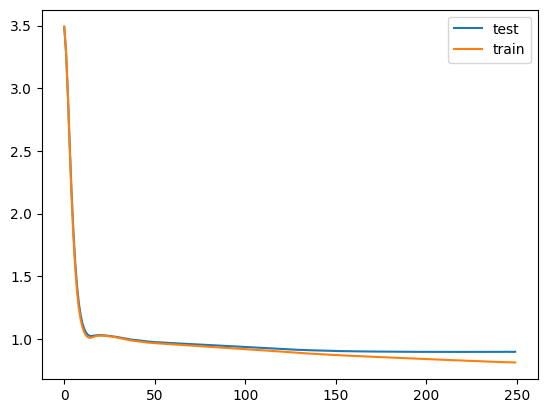

In [32]:
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
plt.legend()

## Result analysis

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [34]:
!python generate.py --name ./dataset/ratings_train.npy

Ratings loading...
Ratings Loaded.
Epoch [1/130], Loss: 0.011266
Epoch [2/130], Loss: 0.010260
Epoch [3/130], Loss: 0.009457
Epoch [4/130], Loss: 0.008800
Epoch [5/130], Loss: 0.008250
Epoch [6/130], Loss: 0.007777
Epoch [7/130], Loss: 0.007372
Epoch [8/130], Loss: 0.007034
Epoch [9/130], Loss: 0.006761
Epoch [10/130], Loss: 0.006552
Epoch [11/130], Loss: 0.006406
Epoch [12/130], Loss: 0.006314
Epoch [13/130], Loss: 0.006267
Epoch [14/130], Loss: 0.006253
Epoch [15/130], Loss: 0.006261
Epoch [16/130], Loss: 0.006280
Epoch [17/130], Loss: 0.006300
Epoch [18/130], Loss: 0.006314
Epoch [19/130], Loss: 0.006323
Epoch [20/130], Loss: 0.006326
Epoch [21/130], Loss: 0.006323
Epoch [22/130], Loss: 0.006315
Epoch [23/130], Loss: 0.006305
Epoch [24/130], Loss: 0.006293
Epoch [25/130], Loss: 0.006281
Epoch [26/130], Loss: 0.006271
Epoch [27/130], Loss: 0.006261
Epoch [28/130], Loss: 0.006254
Epoch [29/130], Loss: 0.006248
Epoch [30/130], Loss: 0.006244
Epoch [31/130], Loss: 0.006241
Epoch [32/130

In [35]:
def plot_cm(targets, predictions, model=None, title='Confusion Matrix'):  
    predictions = predictions[targets!=0]
    targets = targets[targets!=0]
    predictions_strings  = [str(prediction) for prediction in predictions]
    targets_strings  = [str(target) for target in targets]
    # Compute the confusion matrix
    cm = confusion_matrix(targets_strings, predictions_strings)
    
    # Display the confusion matrix as a heatmap
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if (model is not None):
        plt.title(f"Confusion Matrix, num_epochs={model.num_epochs}, encoded_dim='{model.encoded_dim}'")
    else: 
        plt.title(title)
    
    plt.colorbar()
    
    classes = ['0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']  # Replace with your class labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [36]:
def RMSE(targets, predictions):
    predictions = predictions[targets!=0]
    targets = targets[targets!=0]
    # Calculate the squared differences between predictions and targets
    squared_errors = (predictions - targets) ** 2

    # Calculate the mean of squared errors
    mean_squared_error = squared_errors.mean()

    # Calculate the square root to get RMSE
    return np.sqrt(mean_squared_error)

0.8913098181744525


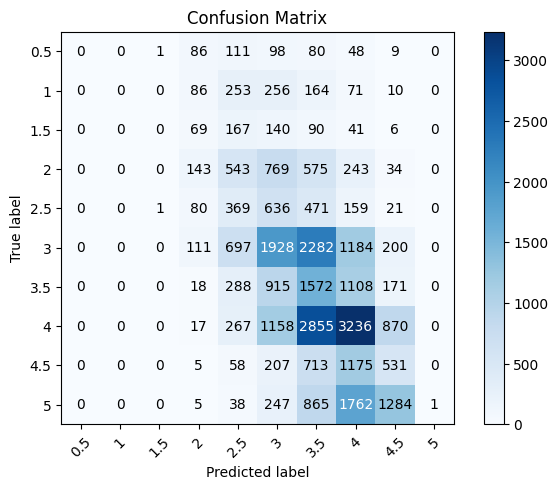

In [37]:
"""
    Use thise cell after running generate.py and assign the used file to calculate the train rmse.

    To have the test RMSE use the test file.
"""

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = np.load('output.npy')
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions)


Epoch [1/250], Loss: 594.939453
Epoch [2/250], Loss: 591.682495
Epoch [3/250], Loss: 588.643799
Epoch [4/250], Loss: 585.586182
Epoch [5/250], Loss: 582.411133
Epoch [6/250], Loss: 579.149170
Epoch [7/250], Loss: 576.043701
Epoch [8/250], Loss: 573.264526
Epoch [9/250], Loss: 570.881226
Epoch [10/250], Loss: 568.922791
Epoch [11/250], Loss: 567.418152
Epoch [12/250], Loss: 566.393127
Epoch [13/250], Loss: 565.788025
Epoch [14/250], Loss: 565.549133
Epoch [15/250], Loss: 565.662476
Epoch [16/250], Loss: 566.127197
Epoch [17/250], Loss: 566.933350
Epoch [18/250], Loss: 568.012573
Epoch [19/250], Loss: 569.319031
Epoch [20/250], Loss: 570.838806
Epoch [21/250], Loss: 572.556824
Epoch [22/250], Loss: 574.390076
Epoch [23/250], Loss: 576.251099
Epoch [24/250], Loss: 578.009888
Epoch [25/250], Loss: 579.538696
Epoch [26/250], Loss: 580.751404
Epoch [27/250], Loss: 581.641052
Epoch [28/250], Loss: 582.251892
Epoch [29/250], Loss: 582.634460
Epoch [30/250], Loss: 582.856567
Epoch [31/250], Los

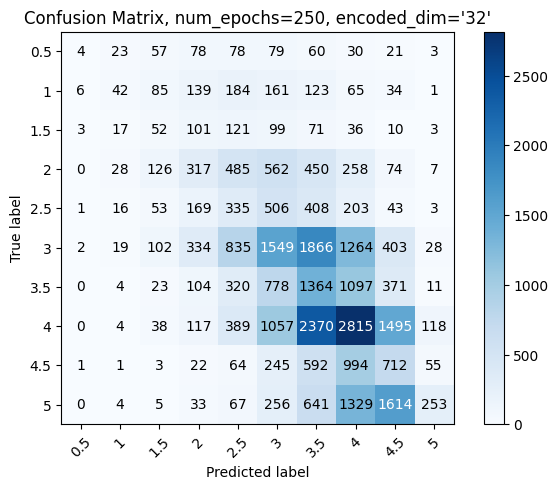

[1.6413944959640503, 1.519777774810791, 1.4245977401733398, 1.3401778936386108, 1.264617919921875, 1.1997473239898682, 1.147166132926941, 1.1070520877838135, 1.0779814720153809, 1.0573697090148926, 1.041976809501648, 1.0284132957458496, 1.0167807340621948, 1.009260654449463, 1.0074747800827026, 1.0107617378234863, 1.0151376724243164, 1.0168253183364868, 1.0142505168914795, 1.0084781646728516, 1.0020618438720703, 0.9966760873794556, 0.9932163953781128, 0.9912457466125488, 0.9891268014907837, 0.9859865307807922, 0.9818572998046875, 0.9773344993591309, 0.9730672240257263, 0.9694177508354187, 0.9665970802307129, 0.9645193219184875, 0.9629235863685608, 0.9613425135612488, 0.9593952894210815, 0.9569624662399292, 0.9541876912117004, 0.9513383507728577, 0.9486933350563049, 0.9463930130004883, 0.9443303346633911, 0.942306399345398, 0.940238356590271, 0.9382582902908325, 0.9364141821861267, 0.9346686601638794, 0.9329427480697632, 0.9311396479606628, 0.929259717464447, 0.9273442029953003, 0.92547

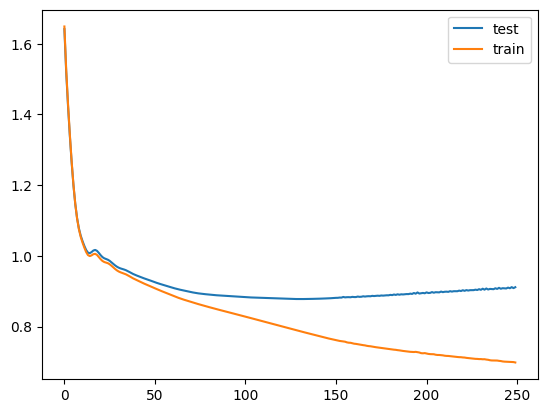

In [38]:
train_set = np.load('./dataset/ratings_train.npy')

train_set[np.isnan(train_set)] = 0
train_set = train_set/np.max(train_set)

test_set = np.load('./dataset/ratings_test.npy')
test_set[np.isnan(test_set)] = 0
encoded_dim = 32
input_size = train_set.shape 
hidden_size_row = 16
hidden_size_col = 64
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
deepMF.train_model(model, optimizer, torch.FloatTensor(train_set), num_epochs=250, lambda_=10, mu_=10, test_data=test_set)
predicted, _, _ = model(torch.FloatTensor(train_set), torch.FloatTensor(train_set).T) 

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = model.numpy_and_round(predicted)
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, model)
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
plt.legend()



# PCA 

### Just for analysis


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [41]:
output = np.load('output.npy')
non_normalized_train_data = np.load('./dataset/ratings_train.npy')
non_normalized_train_data[np.isnan(non_normalized_train_data)] = 0
rmse_per_user = []
for line_output, line_test in zip(output, non_normalized_train_data):
    predictions = line_output[line_test!=0]
    targets = line_test[line_test!=0]
    # Calculate the squared differences between predictions and targets
    squared_errors = (predictions - targets) ** 2

    # Calculate the mean of squared errors
    mean_squared_error = squared_errors.mean()

    # Calculate the square root to get RMSE
    rmse_value = np.sqrt(mean_squared_error)
    rmse_per_user.append(rmse_value)
rmse_per_user = np.array(rmse_per_user)
print(rmse_per_user)

[0.83074716 0.74402381 2.39390251 1.21449578 0.747545   0.89172906
 1.21543109 0.88975652 1.03279556 1.08347268 0.74833148 1.0856203
 0.78173596 1.06800047 1.17260394 0.6413192  0.54906337 0.49363031
 0.8660254  1.02273018 1.01323213 1.54536659 0.58123819 0.43643578
 0.5        0.70710678 1.20585307 0.82388049 0.42257713 0.79056942
 1.01036297 0.67783439 0.96076892 1.29269201 0.82158384 1.
 1.27475488 1.05220856 0.89611958 0.84834956 1.02120377 0.95321597
 0.84016805 0.93541435 0.8503393  0.62678317 1.07529066 0.64549722
 0.44095855 0.70896515 1.04482853 0.71278644 1.29903811 0.62360956
 1.78885438 0.59603956 0.91571921 0.8819171  0.89871703 0.73192505
 0.79930525 0.72796262 0.9009982  0.62834471 0.53452248 0.59702231
 0.74402381 0.9314563  0.72648316 0.56144224 1.07043605 0.36927447
 0.98280674 0.72547625 1.26491106 1.40967354 1.68325082 0.96362411
 0.6751906  0.50507627 1.05220856 0.9686649  1.06066017 0.67566392
 1.26655701 0.56879646 0.70710678 0.42491829 1.18668776 0.82717019
 0.8

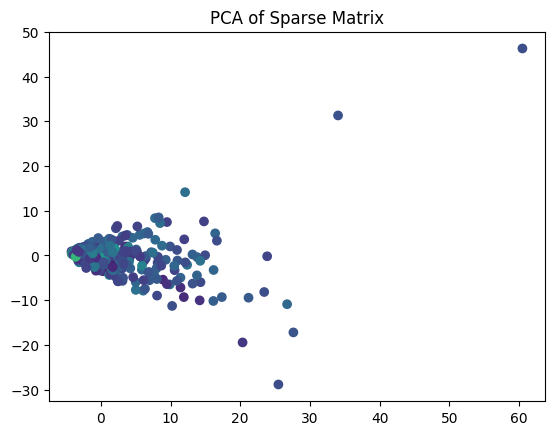

In [42]:
# Generate a random sparse matrix
X = non_normalized_train_data = np.load('./dataset/ratings_train.npy')
X[np.isnan(X)] = 0

n_samples = X.shape[0]
n_features = X.shape[1]

# Perform PCA
n_components = 2  # Number of components to retain
pca = PCA(n_components=n_components)
X_r = pca.fit_transform(X)

# Plot the results
fig = plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], c=rmse_per_user)
plt.title('PCA of Sparse Matrix')
plt.show()


Epoch [1/130], Loss: 0.007502
Epoch [2/130], Loss: 0.007181
Epoch [3/130], Loss: 0.006937
Epoch [4/130], Loss: 0.006742
Epoch [5/130], Loss: 0.006587
Epoch [6/130], Loss: 0.006468
Epoch [7/130], Loss: 0.006384
Epoch [8/130], Loss: 0.006328
Epoch [9/130], Loss: 0.006294
Epoch [10/130], Loss: 0.006276
Epoch [11/130], Loss: 0.006270
Epoch [12/130], Loss: 0.006271
Epoch [13/130], Loss: 0.006275
Epoch [14/130], Loss: 0.006278
Epoch [15/130], Loss: 0.006280
Epoch [16/130], Loss: 0.006279
Epoch [17/130], Loss: 0.006275
Epoch [18/130], Loss: 0.006268
Epoch [19/130], Loss: 0.006259
Epoch [20/130], Loss: 0.006249
Epoch [21/130], Loss: 0.006240
Epoch [22/130], Loss: 0.006232
Epoch [23/130], Loss: 0.006226
Epoch [24/130], Loss: 0.006221
Epoch [25/130], Loss: 0.006217
Epoch [26/130], Loss: 0.006213
Epoch [27/130], Loss: 0.006209
Epoch [28/130], Loss: 0.006204
Epoch [29/130], Loss: 0.006198
Epoch [30/130], Loss: 0.006192
Epoch [31/130], Loss: 0.006185
Epoch [32/130], Loss: 0.006178
Epoch [33/130], L

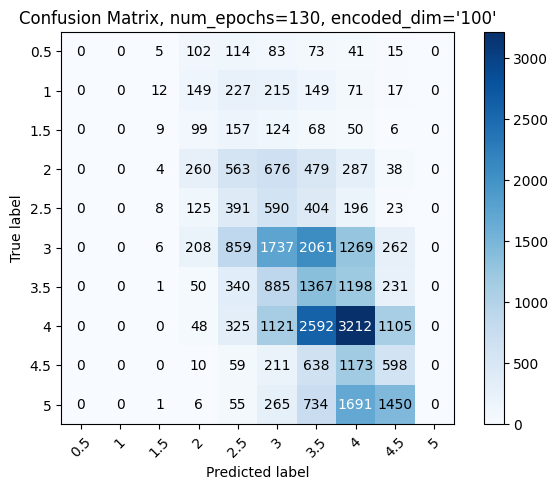

In [43]:
train_set = np.load('./dataset/ratings_train.npy')

train_set[np.isnan(train_set)] = 0
train_set = train_set/np.max(train_set)
test_set = np.load('./dataset/ratings_test.npy')
test_set[np.isnan(test_set)] = 0
encoded_dim = 100
input_size = train_set.shape 
hidden_size_row = 16
hidden_size_col = 64
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
deepMF.train_model(model, optimizer, torch.FloatTensor(train_set), num_epochs=130, lambda_=0, mu_=0)
predicted, _, _ = model(torch.FloatTensor(train_set), torch.FloatTensor(train_set).T) 
targets = test_set
targets[np.isnan(targets)] = 0

predictions = model.numpy_and_round(predicted)
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, model)
